<a href="https://colab.research.google.com/github/geotserga/Fashion-mnist_dataset_Clustering/blob/main/fashion_mnist_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

# Load the dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize the data
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# Flatten the images for PCA and SAE
X_train_flat = X_train.reshape(-1, 28*28)
X_test_flat = X_test.reshape(-1, 28*28)

In [ ]:
# Split the data into train, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Print the shapes to confirm
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)

X_train shape: (54000, 28, 28)
X_val shape: (6000, 28, 28)
X_test shape: (10000, 28, 28)


X_train_pca shape: (60000, 187)
X_test_pca shape: (10000, 187)


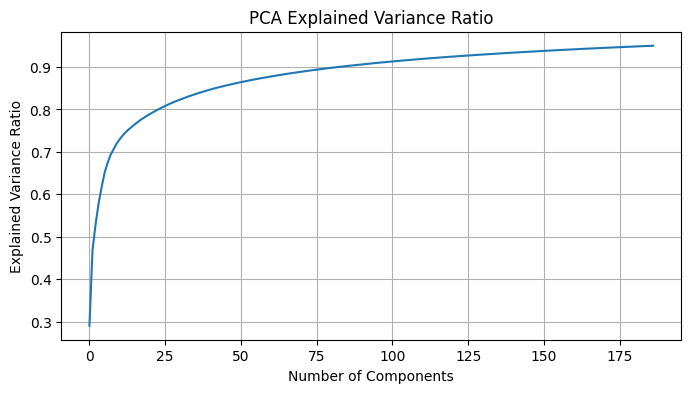

In [ ]:
#Principal Component Analysis (PCA) for dimensionality reduction

from sklearn.decomposition import PCA

# PCA for dimensionality reduction
pca = PCA(n_components=0.95, whiten=True)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

# Print the shapes to confirm
print('X_train_pca shape:', X_train_pca.shape)
print('X_test_pca shape:', X_test_pca.shape)

# Plot explained variance ratio for PCA
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.grid()
plt.show()

Epoch 1/50
235/235 [==============================] - 10s 32ms/step - loss: 0.3777 - val_loss: 0.3180
Epoch 2/50
235/235 [==============================] - 4s 16ms/step - loss: 0.3102 - val_loss: 0.3060
Epoch 3/50
235/235 [==============================] - 4s 16ms/step - loss: 0.3025 - val_loss: 0.3007
Epoch 4/50
235/235 [==============================] - 4s 17ms/step - loss: 0.2981 - val_loss: 0.2969
Epoch 5/50
235/235 [==============================] - 5s 21ms/step - loss: 0.2950 - val_loss: 0.2940
Epoch 6/50
235/235 [==============================] - 4s 17ms/step - loss: 0.2926 - val_loss: 0.2917
Epoch 7/50
235/235 [==============================] - 4s 17ms/step - loss: 0.2905 - val_loss: 0.2906
Epoch 8/50
235/235 [==============================] - 7s 29ms/step - loss: 0.2890 - val_loss: 0.2884
Epoch 9/50
235/235 [==============================] - 4s 17ms/step - loss: 0.2877 - val_loss: 0.2875
Epoch 10/50
235/235 [==============================] - 4s 17ms/step - loss: 0.2865 - val_l

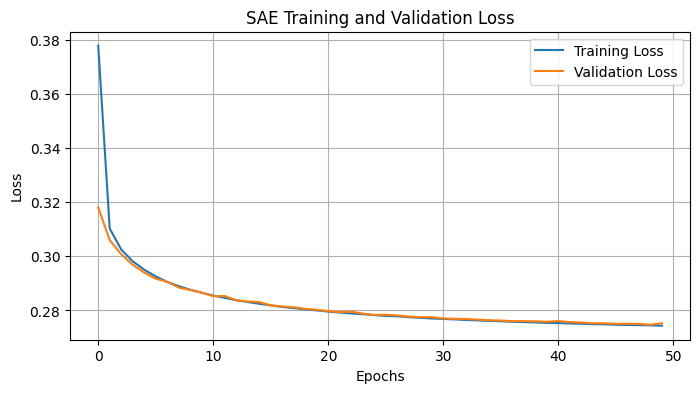

In [ ]:
#Stacked Autoencoder (SAE) for dimensionality reduction

import tensorflow as tf
from tensorflow.keras import layers, models

def build_sae():
    input_img = layers.Input(shape=(784,))
    encoded = layers.Dense(128, activation='relu')(input_img)
    encoded = layers.Dense(64, activation='relu')(encoded)
    encoded = layers.Dense(32, activation='relu')(encoded)

    decoded = layers.Dense(64, activation='relu')(encoded)
    decoded = layers.Dense(128, activation='relu')(decoded)
    decoded = layers.Dense(784, activation='sigmoid')(decoded)

    autoencoder = models.Model(input_img, decoded)
    encoder = models.Model(input_img, encoded)

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder, encoder

autoencoder, encoder = build_sae()
history = autoencoder.fit(X_train_flat, X_train_flat,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_val.reshape(-1, 28*28), X_val.reshape(-1, 28*28)))

X_train_sae = encoder.predict(X_train_flat)
X_test_sae = encoder.predict(X_test_flat)

# Print the shapes to confirm
print('X_train_sae shape:', X_train_sae.shape)
print('X_test_sae shape:', X_test_sae.shape)

# Plot training and validation loss for SAE
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('SAE Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

313/313 [==============================] - 1s 2ms/step


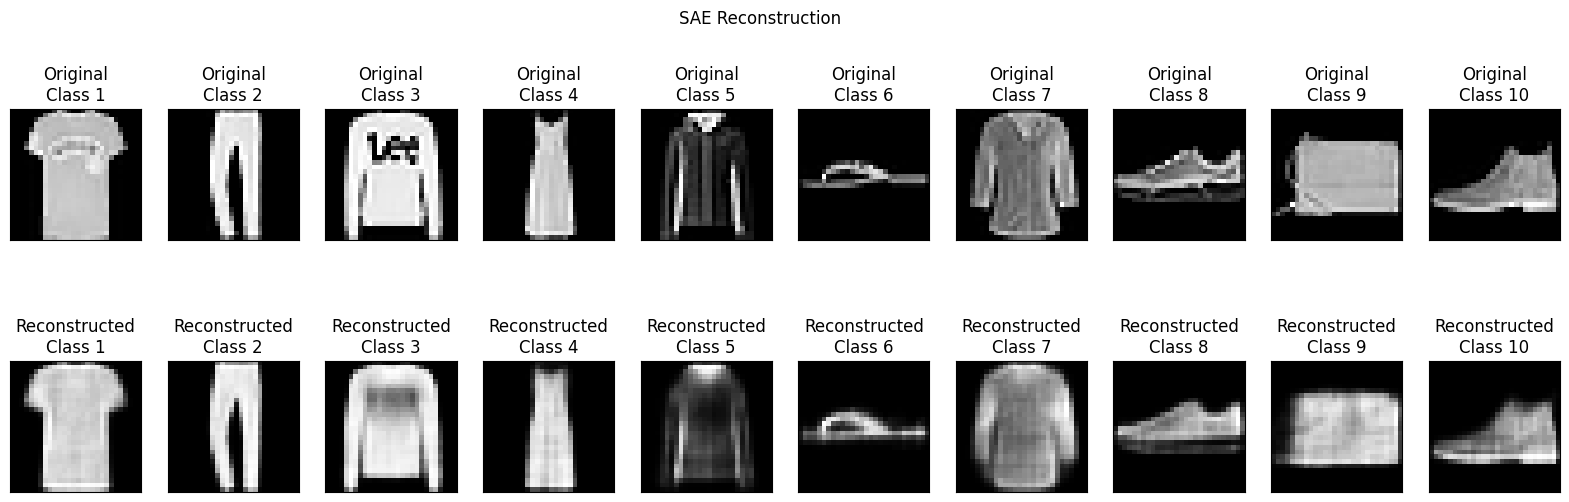

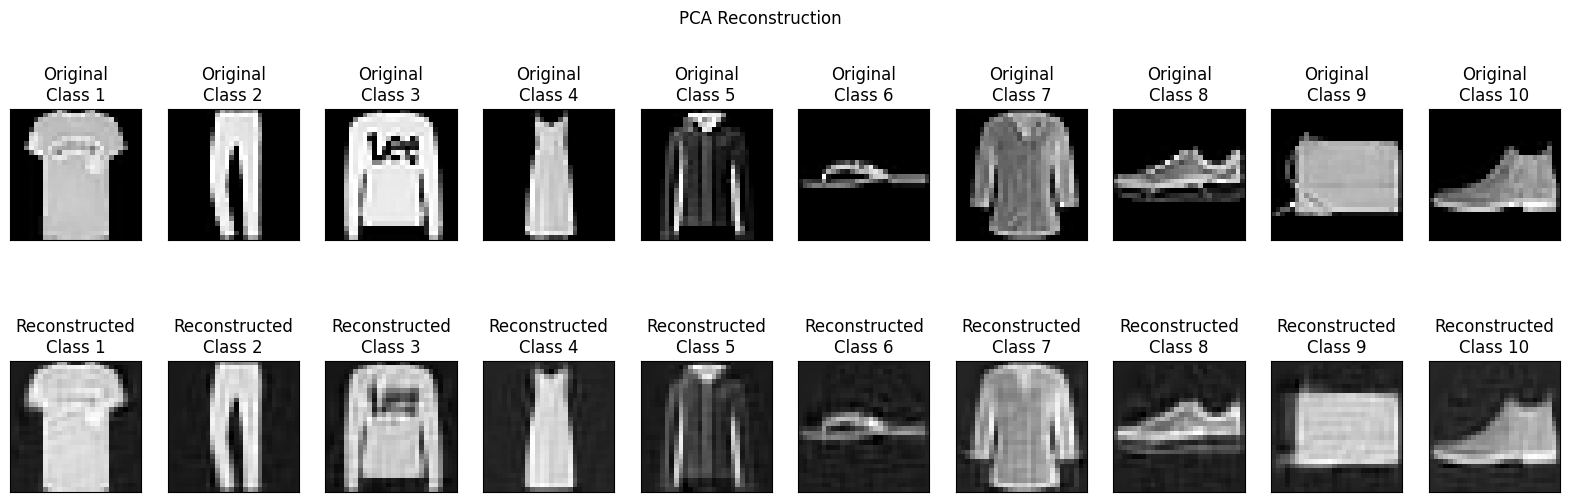

In [ ]:
def plot_images_per_class(orig, recon, labels, title):
    # Find one example from each class
    classes = np.unique(labels)
    samples_per_class = {cls: np.where(labels == cls)[0][0] for cls in classes}

    plt.figure(figsize=(20, 6))
    for i, cls in enumerate(classes):
        idx = samples_per_class[cls]

        # Original images
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(orig[idx].reshape(28, 28))
        plt.title(f"Original\nClass {cls + 1}")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Reconstructed images
        ax = plt.subplot(2, 10, i + 11)
        plt.imshow(recon[idx].reshape(28, 28))
        plt.title(f"Reconstructed\nClass {cls + 1}")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title)
    plt.show()

# Plot sample original and reconstructed images for SAE
reconstructed = autoencoder.predict(X_test_flat)
plot_images_per_class(X_test, reconstructed.reshape(-1, 28, 28), y_test, "SAE Reconstruction")

# Plot sample original and reconstructed images for PCA
reconstructed_pca = pca.inverse_transform(X_test_pca)
plot_images_per_class(X_test, reconstructed_pca.reshape(-1, 28, 28), y_test, "PCA Reconstruction")

In [ ]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
import seaborn as sns
import time

def clustering_with_minibatch_kmeans(X_train, X_test, n_clusters):
    start_time = time.time()
    mbk = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    mbk.fit(X_train)
    training_time = time.time() - start_time

    start_time = time.time()
    test_labels = mbk.predict(X_test)
    execution_time = time.time() - start_time

    ch_score = calinski_harabasz_score(X_test, test_labels)
    db_score = davies_bouldin_score(X_test, test_labels)
    silhouette_avg = silhouette_score(X_test, test_labels)

    return test_labels, training_time, execution_time, ch_score, db_score, silhouette_avg

def clustering_with_kmeans(X_train, X_test, n_clusters):
    start_time = time.time()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(X_train)
    training_time = time.time() - start_time

    start_time = time.time()
    test_labels = kmeans.predict(X_test)
    execution_time = time.time() - start_time

    ch_score = calinski_harabasz_score(X_test, test_labels)
    db_score = davies_bouldin_score(X_test, test_labels)
    silhouette_avg = silhouette_score(X_test, test_labels)

    return test_labels, training_time, execution_time, ch_score, db_score, silhouette_avg

n_clusters = 10

# Clustering for Raw Data
test_labels_raw_mbk, training_time_raw_mbk, execution_time_raw_mbk, ch_score_raw_mbk, db_score_raw_mbk, silhouette_avg_raw_mbk = clustering_with_minibatch_kmeans(X_train_flat, X_test_flat, n_clusters)
test_labels_raw_kmeans, training_time_raw_kmeans, execution_time_raw_kmeans, ch_score_raw_kmeans, db_score_raw_kmeans, silhouette_avg_raw_kmeans = clustering_with_kmeans(X_train_flat, X_test_flat, n_clusters)

# Clustering for PCA Data
test_labels_pca_mbk, training_time_pca_mbk, execution_time_pca_mbk, ch_score_pca_mbk, db_score_pca_mbk, silhouette_avg_pca_mbk = clustering_with_minibatch_kmeans(X_train_pca, X_test_pca, n_clusters)
test_labels_pca_kmeans, training_time_pca_kmeans, execution_time_pca_kmeans, ch_score_pca_kmeans, db_score_pca_kmeans, silhouette_avg_pca_kmeans = clustering_with_kmeans(X_train_pca, X_test_pca, n_clusters)

# Clustering for SAE Data
test_labels_sae_mbk, training_time_sae_mbk, execution_time_sae_mbk, ch_score_sae_mbk, db_score_sae_mbk, silhouette_avg_sae_mbk = clustering_with_minibatch_kmeans(X_train_sae, X_test_sae, n_clusters)
test_labels_sae_kmeans, training_time_sae_kmeans, execution_time_sae_kmeans, ch_score_sae_kmeans, db_score_sae_kmeans, silhouette_avg_sae_kmeans = clustering_with_kmeans(X_train_sae, X_test_sae, n_clusters)

In [ ]:
# Create an empty list to store the results
results_list = []

# Adding the results for Raw Data + MiniBatchKMeans
results_list.append({
    'Dimensionality Reduction': 'Raw',
    'Clustering Algorithm': 'MiniBatchKMeans',
    'Training Time (s)': training_time_raw_mbk,
    'Execution Time (s)': execution_time_raw_mbk,
    'Number of Clusters': n_clusters,
    'Calinski-Harabasz Index': ch_score_raw_mbk,
    'Davies-Bouldin Index': db_score_raw_mbk,
    'Silhouette Score': silhouette_avg_raw_mbk
})

# Adding the results for Raw Data + KMeans
results_list.append({
    'Dimensionality Reduction': 'Raw',
    'Clustering Algorithm': 'KMeans',
    'Training Time (s)': training_time_raw_kmeans,
    'Execution Time (s)': execution_time_raw_kmeans,
    'Number of Clusters': n_clusters,
    'Calinski-Harabasz Index': ch_score_raw_kmeans,
    'Davies-Bouldin Index': db_score_raw_kmeans,
    'Silhouette Score': silhouette_avg_raw_kmeans
})

# Adding the results for PCA + MiniBatchKMeans
results_list.append({
    'Dimensionality Reduction': 'PCA',
    'Clustering Algorithm': 'MiniBatchKMeans',
    'Training Time (s)': training_time_pca_mbk,
    'Execution Time (s)': execution_time_pca_mbk,
    'Number of Clusters': n_clusters,
    'Calinski-Harabasz Index': ch_score_pca_mbk,
    'Davies-Bouldin Index': db_score_pca_mbk,
    'Silhouette Score': silhouette_avg_pca_mbk
})

# Adding the results for PCA + KMeans
results_list.append({
    'Dimensionality Reduction': 'PCA',
    'Clustering Algorithm': 'KMeans',
    'Training Time (s)': training_time_pca_kmeans,
    'Execution Time (s)': execution_time_pca_kmeans,
    'Number of Clusters': n_clusters,
    'Calinski-Harabasz Index': ch_score_pca_kmeans,
    'Davies-Bouldin Index': db_score_pca_kmeans,
    'Silhouette Score': silhouette_avg_pca_kmeans
})

# Adding the results for SAE + MiniBatchKMeans
results_list.append({
    'Dimensionality Reduction': 'SAE',
    'Clustering Algorithm': 'MiniBatchKMeans',
    'Training Time (s)': training_time_sae_mbk,
    'Execution Time (s)': execution_time_sae_mbk,
    'Number of Clusters': n_clusters,
    'Calinski-Harabasz Index': ch_score_sae_mbk,
    'Davies-Bouldin Index': db_score_sae_mbk,
    'Silhouette Score': silhouette_avg_sae_mbk
})

# Adding the results for SAE + KMeans
results_list.append({
    'Dimensionality Reduction': 'SAE',
    'Clustering Algorithm': 'KMeans',
    'Training Time (s)': training_time_sae_kmeans,
    'Execution Time (s)': execution_time_sae_kmeans,
    'Number of Clusters': n_clusters,
    'Calinski-Harabasz Index': ch_score_sae_kmeans,
    'Davies-Bouldin Index': db_score_sae_kmeans,
    'Silhouette Score': silhouette_avg_sae_kmeans
})

# Create a DataFrame from the list of results
results = pd.DataFrame(results_list)

# Display results
print(results)

  Dimensionality Reduction Clustering Algorithm  Training Time (s)  \
0                      Raw      MiniBatchKMeans           2.241831   
1                      Raw               KMeans           8.032817   
2                      PCA      MiniBatchKMeans           0.211136   
3                      PCA               KMeans           4.069616   
4                      SAE      MiniBatchKMeans           0.188882   
5                      SAE               KMeans           0.281111   

   Execution Time (s)  Number of Clusters  Calinski-Harabasz Index  \
0            0.016117                  10              1236.226683   
1            0.029922                  10              1246.284706   
2            0.004002                  10                29.342215   
3            0.008204                  10                40.156579   
4            0.001255                  10              2165.710061   
5            0.001494                  10              2250.133470   

   Davies-Bouldin 

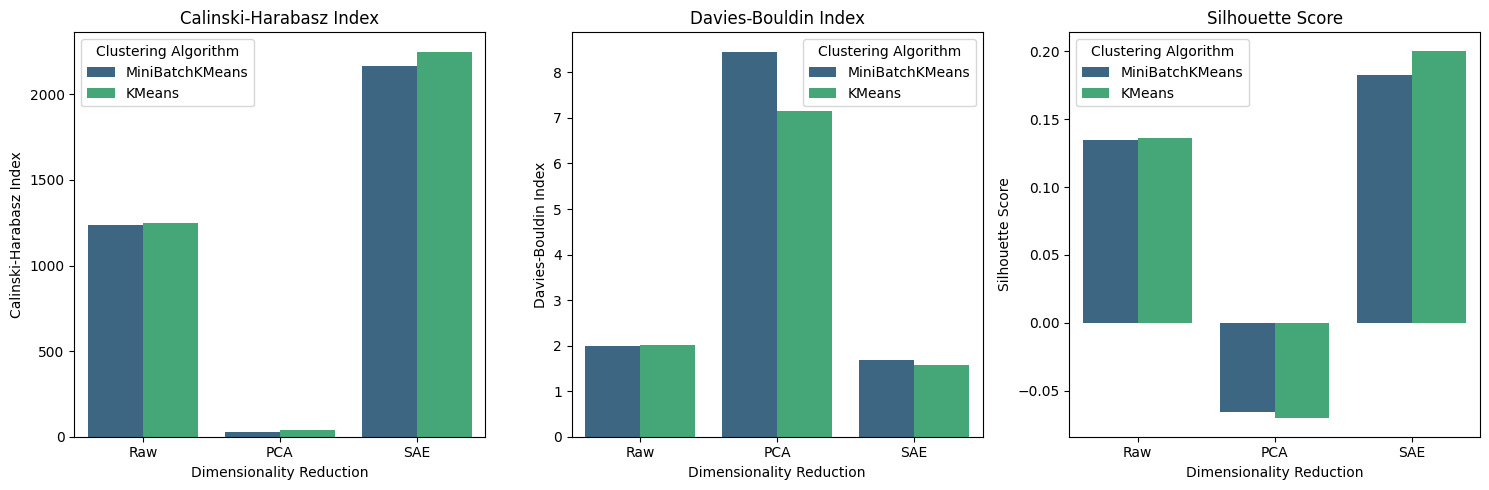

In [ ]:
# Results visualization
import seaborn as sns

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.barplot(x='Dimensionality Reduction', y='Calinski-Harabasz Index', hue='Clustering Algorithm',palette='viridis', data=results)
plt.title('Calinski-Harabasz Index')

plt.subplot(1, 3, 2)
sns.barplot(x='Dimensionality Reduction', y='Davies-Bouldin Index', hue='Clustering Algorithm', palette='viridis', data=results)
plt.title('Davies-Bouldin Index')

plt.subplot(1, 3, 3)
sns.barplot(x='Dimensionality Reduction', y='Silhouette Score', hue='Clustering Algorithm',palette='viridis', data=results)
plt.title('Silhouette Score')

plt.tight_layout()
plt.show()

In [ ]:
def plot_cluster_images(X, labels, cluster_id):
    cluster_images = X[labels == cluster_id]
    selected_images = cluster_images[np.random.choice(cluster_images.shape[0], 10, replace=False)]

    plt.figure(figsize=(10, 2))
    for i, img in enumerate(selected_images):
        plt.subplot(1, 10, i + 1)
        plt.imshow(img.reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Cluster {cluster_id}')
    plt.show()

  Dimensionality Reduction Clustering Algorithm  Training Time (s)  \
2                      PCA      MiniBatchKMeans           0.211136   
1                      Raw               KMeans           8.032817   
5                      SAE               KMeans           0.281111   

   Execution Time (s)  Number of Clusters  Calinski-Harabasz Index  \
2            0.004002                  10                29.342215   
1            0.029922                  10              1246.284706   
5            0.001494                  10              2250.133470   

   Davies-Bouldin Index  Silhouette Score  
2              8.456959         -0.065596  
1              2.009225          0.136241  
5              1.572669          0.200443  
Best overall result:
Dimensionality Reduction           SAE
Clustering Algorithm            KMeans
Training Time (s)             0.281111
Execution Time (s)            0.001494
Number of Clusters                  10
Calinski-Harabasz Index     2250.13347
Davies-

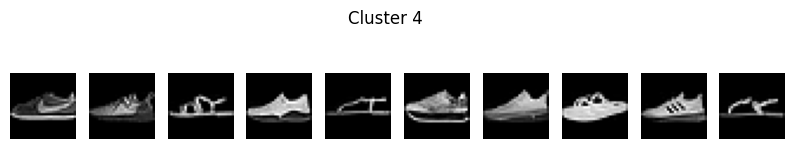

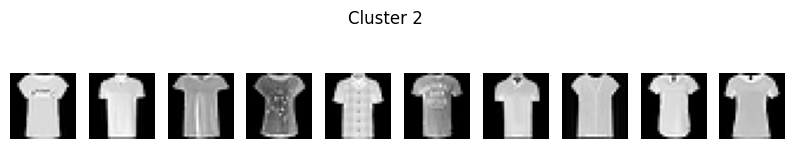

In [ ]:
# Choosing the clustering technique with the best silhouette score for each dimension reduction technique
best_results = results.loc[results.groupby('Dimensionality Reduction')['Silhouette Score'].idxmax()]

# Show the best result
print(best_results)

# Choosing the technique that gave the best overall result
best_overall_result = best_results.loc[best_results['Silhouette Score'].idxmax()]
print("Best overall result:")
print(best_overall_result)

# Recovery of the labels from the clustering technique that gave the best results
if best_overall_result['Dimensionality Reduction'] == 'Raw':
    if best_overall_result['Clustering Algorithm'] == 'MiniBatchKMeans':
        best_labels = test_labels_raw_mbk
    else:
        best_labels = test_labels_raw_kmeans
elif best_overall_result['Dimensionality Reduction'] == 'PCA':
    if best_overall_result['Clustering Algorithm'] == 'MiniBatchKMeans':
        best_labels = test_labels_pca_mbk
    else:
        best_labels = test_labels_pca_kmeans
else:
    if best_overall_result['Clustering Algorithm'] == 'MiniBatchKMeans':
        best_labels = test_labels_sae_mbk
    else:
        best_labels = test_labels_sae_kmeans

# Choosing two random clusters
import random
unique_labels = np.unique(best_labels)
selected_clusters = random.sample(list(unique_labels), 2)

# Display 10 random images from each selected cluster
print(f"Selected clusters: {selected_clusters}")
for cluster_id in selected_clusters:
    plot_cluster_images(X_test, best_labels, cluster_id)